<a href="https://colab.research.google.com/github/bluebynick/CEE-9730-Data-Science-for-Geotechnical-Engineers/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Files exist?
75kpa.xlsx True
150 kpa.xlsx True
final idk.xlsx True
idk.xlsx True
Train: (18850, 6) Val: (4713, 6) Test: (3405, 6)
Training with lr = 0.01
Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4437 - loss: 4258.0698 - val_accuracy: 0.6235 - val_loss: 0.9077
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6162 - loss: 1.0458 - val_accuracy: 0.6194 - val_loss: 0.9117
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6203 - loss: 0.9074 - val_accuracy: 0.6199 - val_loss: 0.9080
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6193 - loss: 0.9061 - val_accuracy: 0.6175 - val_loss: 0.9140
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6201 - loss: 0.9073 - val_accuracy: 0.6171 - val_loss: 0.9112
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6197 - loss: 0.9071 - val_accuracy: 0.6173 - val_loss: 0.9060
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

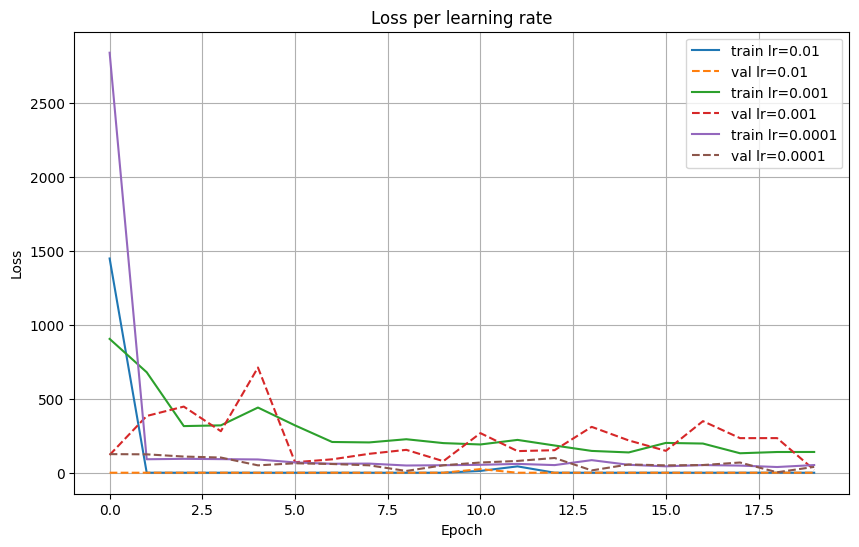

<Figure size 1000x600 with 0 Axes>

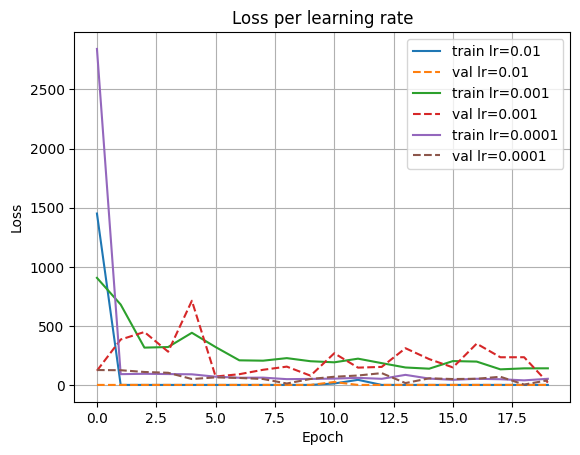

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, Model

#variables
BATCH_SIZE = 64;
EPOCHS = 20;
N_CLASSES = 3;
histories = {}
LOW_THRESHOLD = 3.0
HIGH_THRESHOLD = 10.0

#get the files. i'd tried with zip files but it ended horribly so i restarted lol
testA = os.path.join("/content/drive/MyDrive/Master's/Nick/75kpa", "75kpa.xlsx")
testB = os.path.join("/content/drive/MyDrive/Master's/Nick/150kpa - f", "150 kpa.xlsx")
testC = os.path.join("/content/drive/MyDrive/Master's/Nick/test 3", "final idk.xlsx")
testD = os.path.join("/content/drive/MyDrive/Master's/Nick/test 4", "idk.xlsx")
print("Files exist?")
for f in [testA, testB, testC, testD]:
    print(os.path.basename(f), os.path.exists(f))

#the pari____ng method
#
SHEAR_SHEET_NAME = "1|4|1"   # shear stage sheet name in your Excel

def load_shear_data(path, test_label):
    """ #OMG MULTILINE COMMENTS HOLY F
    path: path to Excel file
    test_label: "A", "B", "C", or "D"
    returns: DataFrame with features + axial strain
    """
    raw = pd.read_excel(path, sheet_name=SHEAR_SHEET_NAME)

    # find the header row where "Deviator Stress" appears
    mask = raw.apply(
        lambda row: row.astype(str).str.contains("Deviator Stress", case=False, na=False).any(),
        axis=1
    )
    header_row = raw[mask].index[-1]  # last occurrence
    header = raw.iloc[header_row].tolist()
    header = [h if isinstance(h, str) and h == h else f"col_{i}"
              for i, h in enumerate(header)]

    data = raw.iloc[header_row+1:].reset_index(drop=True)
    data.columns = header

    # keep the columns we care about
    cols = [
        "Time",
        "Corrected Deviator Stress",
        "Axial Strain",
        "Volumetric Strain",
        "Minor Effective Stress",
        "Major Effective Stress",
        "Effective Stress Ratio",
        "Effective Normal Stress",
    ]
    cols = [c for c in cols if c in data.columns]  # handle missing extras
    data = data[cols].copy()

    data["Test"] = test_label
    return data

def batch_gen(X, y, batch_size=BATCH_SIZE):
    n = X.shape[0]
    i = 0
    while True:
        idx = np.arange(i, i + batch_size) % n
        batch_x = X[idx]
        batch_y = y[idx]
        i += batch_size
        yield batch_x, batch_y


def build_unet(input_shape, num_classes=N_CLASSES):
    """
    Small MLP classifier. Keeping the name 'build_unet' so the rest
    of the training loop doesn't need to change.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

#let's run this bad boy
#pass the different folders we have to the pairing method. idk if i should pass test / train_extra too tho
# 1. Load four tests into one DataFrame
df_A = load_shear_data(testA, "A")
df_B = load_shear_data(testB, "B")
df_C = load_shear_data(testC, "C")
df_D = load_shear_data(testD, "D")

dfs = [df_A, df_B, df_C, df_D]

# 2. Make a risk label from Axial Strain
def strain_to_risk(ea):
    ea = float(ea)
    if ea < LOW_THRESHOLD:
        return 0   # low
    elif ea < HIGH_THRESHOLD:
        return 1   # moderate
    else:
        return 2   # high

for df in dfs:
    df["risk"] = pd.to_numeric(df["Axial Strain"], errors="coerce").apply(strain_to_risk)

all_df = pd.concat(dfs, ignore_index=True)

# 3. Train/val = A,B,C ; Test = D
train_df = all_df[all_df["Test"].isin(["A","B","C"])].copy()
test_df  = all_df[all_df["Test"] == "D"].copy()

from sklearn.model_selection import train_test_split

feature_cols = [c for c in train_df.columns if c not in ["Axial Strain", "Volumetric Strain", "risk", "Test"]]

X = train_df[feature_cols].to_numpy().astype("float32")
y = train_df["risk"].to_numpy().astype("int32")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

X_test = test_df[feature_cols].to_numpy().astype("float32")
y_test = test_df["risk"].to_numpy().astype("int32")

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# 4. Generators
train_gen = batch_gen(X_train, y_train, BATCH_SIZE)
val_gen   = batch_gen(X_val, y_val, BATCH_SIZE)

steps_per_epoch = len(X_train) // BATCH_SIZE
val_steps       = max(1, len(X_val) // BATCH_SIZE)




#pass the # of classes to build the model, for each each training rate
for lr in [1e-2, 1e-3, 1e-4]:
    print("Training with lr =", lr)
    model = build_unet(input_shape=(X_train.shape[1],), num_classes=N_CLASSES)
    opt = tf.keras.optimizers.Adam(lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    h = model.fit(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        epochs=EPOCHS,
        verbose=1
    )
    histories[lr] = h.history

#plot the training and validation loss curve at each learning rate
plt.figure(figsize=(10,6))
for lr, hist in histories.items():
    plt.plot(hist['loss'], label=f"train lr={lr}")
    plt.plot(hist['val_loss'], '--', label=f"val lr={lr}")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per learning rate"); plt.legend(); plt.grid(True); plt.figure(figsize=(10,6))
plt.show()

for lr, hist in histories.items():
    plt.plot(hist['loss'], label=f"train lr={lr}")
    plt.plot(hist['val_loss'], '--', label=f"val lr={lr}")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per learning rate"); plt.legend(); plt.grid(True)
plt.show()



#How to actually test it (numbers time)
# 1. Train one "final" model at the best LR
best_lr = 1e-3  # or whichever looked best in your loss plot

model = build_unet(input_shape=(X_train.shape[1],), num_classes=N_CLASSES)
opt = tf.keras.optimizers.Adam(best_lr)
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
history = model.fit(
    batch_gen(X_train, y_train, BATCH_SIZE),
    validation_data=batch_gen(X_val, y_val, BATCH_SIZE),
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=max(1, len(X_val)//BATCH_SIZE),
    epochs=EPOCHS,
    verbose=1
)

# 2. Evaluate on validation + test sets *properly*
from sklearn.metrics import classification_report, confusion_matrix

# validation set
val_probs = model.predict(X_val)
val_pred = np.argmax(val_probs, axis=1)

print("Validation performance:")
print(classification_report(
    y_val, val_pred,
    target_names=["low", "moderate", "high"]
))
print("Confusion matrix (val):")
print(confusion_matrix(y_val, val_pred))

# test set (this is your "unknown" Test D)
test_probs = model.predict(X_test)
test_pred = np.argmax(test_probs, axis=1)

print("\nTest performance on weird Test D:")
print(classification_report(
    y_test, test_pred,
    target_names=["low", "moderate", "high"]
))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, test_pred))



#A visual “proof” that feels satisfying
# and feature_cols / X_test / y_test defined like before

test_probs = model.predict(X_test)
test_pred = np.argmax(test_probs, axis=1)  # 0=low,1=mod,2=high

axial_strain = test_df["Axial Strain"].to_numpy().astype(float)
deviator_stress = test_df["Corrected Deviator Stress"].to_numpy().astype(float)

plt.figure(figsize=(8,5))
scatter = plt.scatter(
    axial_strain,
    deviator_stress,
    c=test_pred,
    cmap="viridis",
    s=8
)
plt.xlabel("Axial Strain (%)")
plt.ylabel("Deviator Stress (kPa)")
plt.title("Model-predicted risk along the stress–strain curve (Test D)")
plt.colorbar(scatter, ticks=[0,1,2], label="Risk level")
plt.clim(-0.5, 2.5)
plt.show()

